In [ ]:
from google.colab import drive

In [ ]:
drive.mount("/content/drive")

Mounted at /content/drive


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report

BATCH_SIZE = 32
IMAGE_SIZE = 256
CHANNELS = 3
EPOCHS = 30

# Load and preprocess the dataset
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "/content/drive/MyDrive/vn_data",
    seed=123,
    shuffle=True,
    image_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE
)


Found 2030 files belonging to 2 classes.


In [ ]:
class_names = dataset.class_names
class_names

['benign', 'malignant']

In [ ]:
for image_batch, labels_batch in dataset.take(1):
    print(image_batch.shape)
    print(labels_batch.numpy())

(32, 256, 256, 3)
[0 1 1 1 1 0 0 0 1 1 1 1 0 1 0 0 1 0 0 1 1 1 1 1 1 1 1 0 1 1 1 1]


In [ ]:
plt.figure(figsize=(10, 10))
for image_batch, labels_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3, 4, i + 1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[labels_batch[i]])
        plt.axis("off")

In [ ]:
def get_dataset_partitions_tf(ds, train_split=0.7, val_split=0.2, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1
    ds_size = len(ds)
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    train_ds = ds.take(train_size)
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    return train_ds, val_ds, test_ds

In [ ]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [ ]:
# Print dataset information
print("Number of batches in train dataset Before Augmentation:", len(train_ds))
print("Number of batches in validation dataset:", len(val_ds))
print("Number of batches in test dataset:", len(test_ds))

Number of batches in train dataset Before Augmentation: 51
Number of batches in validation dataset: 6
Number of batches in test dataset: 7


In [ ]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [ ]:
data_augmentation = tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    layers.experimental.preprocessing.RandomRotation(0.2),])
# Create a dataset with one batch of augmented data
augmented_batch = train_ds.take(1).map(lambda x, y: (data_augmentation(x, training=True), y))
# Concatenate the augmented batch with the original train dataset
augmented_train_ds = train_ds.concatenate(augmented_batch)
# Prefetch the augmented dataset for better performance
train_ds = augmented_train_ds.prefetch(buffer_size=tf.data.AUTOTUNE)

In [ ]:
data_augmentation = tf.keras.Sequential([
    layers.GaussianBlur(3),  # Adding blur
    layers.experimental.preprocessing.RandomContrast(0.2),  # Adjusting contrast
    layers.experimental.preprocessing.RandomBrightness(0.2),  # Adjusting brightness
    layers.GaussianNoise(0.1),  # Adding noise for variation
    layers.Conv2D(1, (3, 3), padding='same', activation='relu', kernel_initializer='glorot_uniform'),  # Adding sharpness
])

In [ ]:
# Print dataset information
print("Number of batches in train dataset After Augmentation :", len(train_ds))
print("Number of batches in validation dataset:", len(val_ds))
print("Number of batches in test dataset:", len(test_ds))

Number of batches in train dataset After Augmentation : 52
Number of batches in validation dataset: 6
Number of batches in test dataset: 7


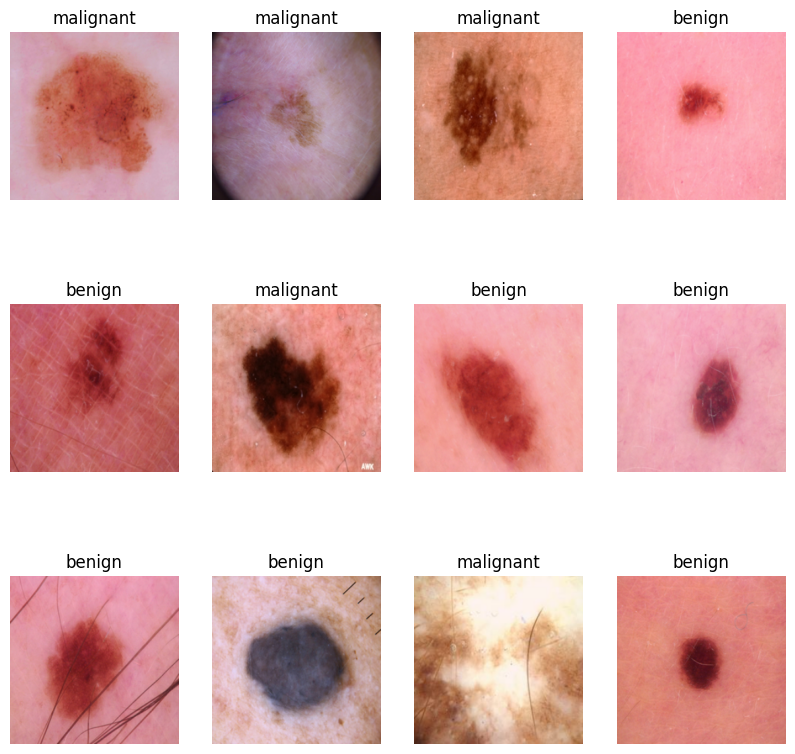

In [ ]:
plt.figure(figsize=(10, 10))
for image_batch, labels_batch in train_ds.take(1):
    for i in range(12):
        ax = plt.subplot(3, 4, i + 1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[labels_batch[i]])
        plt.axis("off")

In [ ]:
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Define constants
IMAGE_SIZE = 256  # Adjust this to match your dataset's image size
NUM_CLASSES = 2  # Number of classes in your dataset
BATCH_SIZE = 25
EPOCHS = 20

# Load the pre-trained ResNet-50 model
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3))

# Freeze the layers of the base model
for layer in base_model.layers:
    layer.trainable = False

# Add custom classification layers on top of the base model
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)  # You can adjust the number of units as needed
predictions = Dense(2, activation='softmax')(x)

# Create the fine-tuned model
model = Model(inputs=base_model.input, outputs=predictions)

# Compile the model
# Compile the model with 'sparse_categorical_crossentropy' as the loss function
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

94765736/94765736 [==============================] - 0s 0us/step


In [ ]:
# Train the model
history = model.fit(train_ds, validation_data=val_ds, epochs=EPOCHS)

Epoch 1/20
52/52 [==============================] - 22s 280ms/step - loss: 0.4989 - accuracy: 0.8323 - val_loss: 0.1875 - val_accuracy: 0.9062
Epoch 2/20
52/52 [==============================] - 7s 132ms/step - loss: 0.2166 - accuracy: 0.9087 - val_loss: 0.1367 - val_accuracy: 0.9635
Epoch 3/20
52/52 [==============================] - 8s 150ms/step - loss: 0.1499 - accuracy: 0.9411 - val_loss: 0.0966 - val_accuracy: 0.9740
Epoch 4/20
52/52 [==============================] - 7s 132ms/step - loss: 0.1292 - accuracy: 0.9465 - val_loss: 0.0889 - val_accuracy: 0.9740
Epoch 5/20
52/52 [==============================] - 7s 145ms/step - loss: 0.1280 - accuracy: 0.9363 - val_loss: 0.0852 - val_accuracy: 0.9792
Epoch 6/20
52/52 [==============================] - 8s 146ms/step - loss: 0.0773 - accuracy: 0.9694 - val_loss: 0.1077 - val_accuracy: 0.9583
Epoch 7/20
52/52 [==============================] - 7s 131ms/step - loss: 0.0641 - accuracy: 0.9766 - val_loss: 0.0762 - val_accuracy: 0.9792
Epoch

7/7 [==============================] - 8s 114ms/step - loss: 0.1086 - accuracy: 0.9777


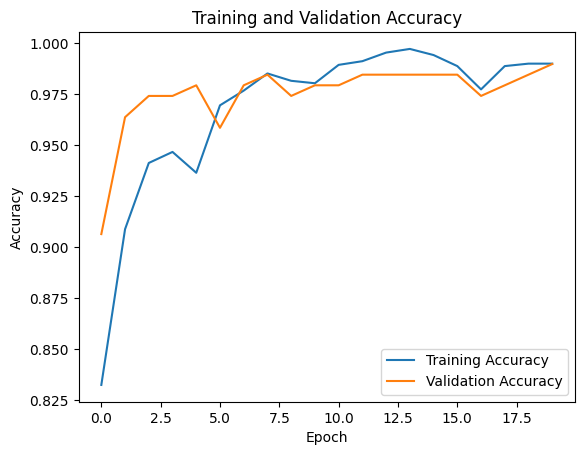

In [ ]:
# Evaluate the model on the test dataset
test_loss, test_accuracy = model.evaluate(test_ds)

# Plot training and validation accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

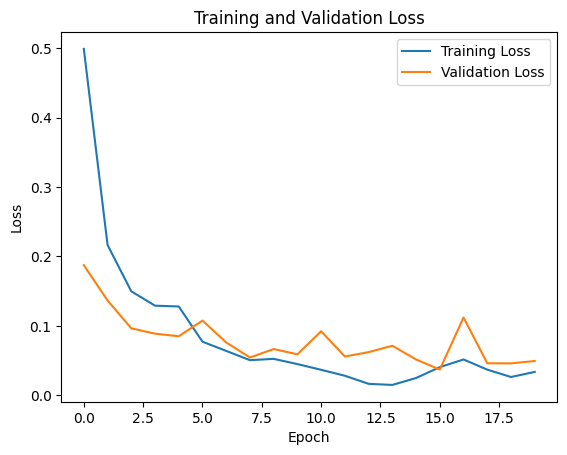

In [ ]:
# Plot training and validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
# Save the model
model.save("/content/drive/MyDrive/model_cancer_detection.h5")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
# Load the saved model
model = tf.keras.models.load_model("/content/drive/MyDrive/model_cancer_detection.h5")

# Evaluate the model on the test dataset
test_loss, test_accuracy = model.evaluate(test_ds)

print(f"Test Accuracy: {test_accuracy}")

7/7 [==============================] - 2s 116ms/step - loss: 0.1086 - accuracy: 0.9777
Test Accuracy: 0.9776785969734192


In [ ]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

1/1 [==============================] - 0s 23ms/step


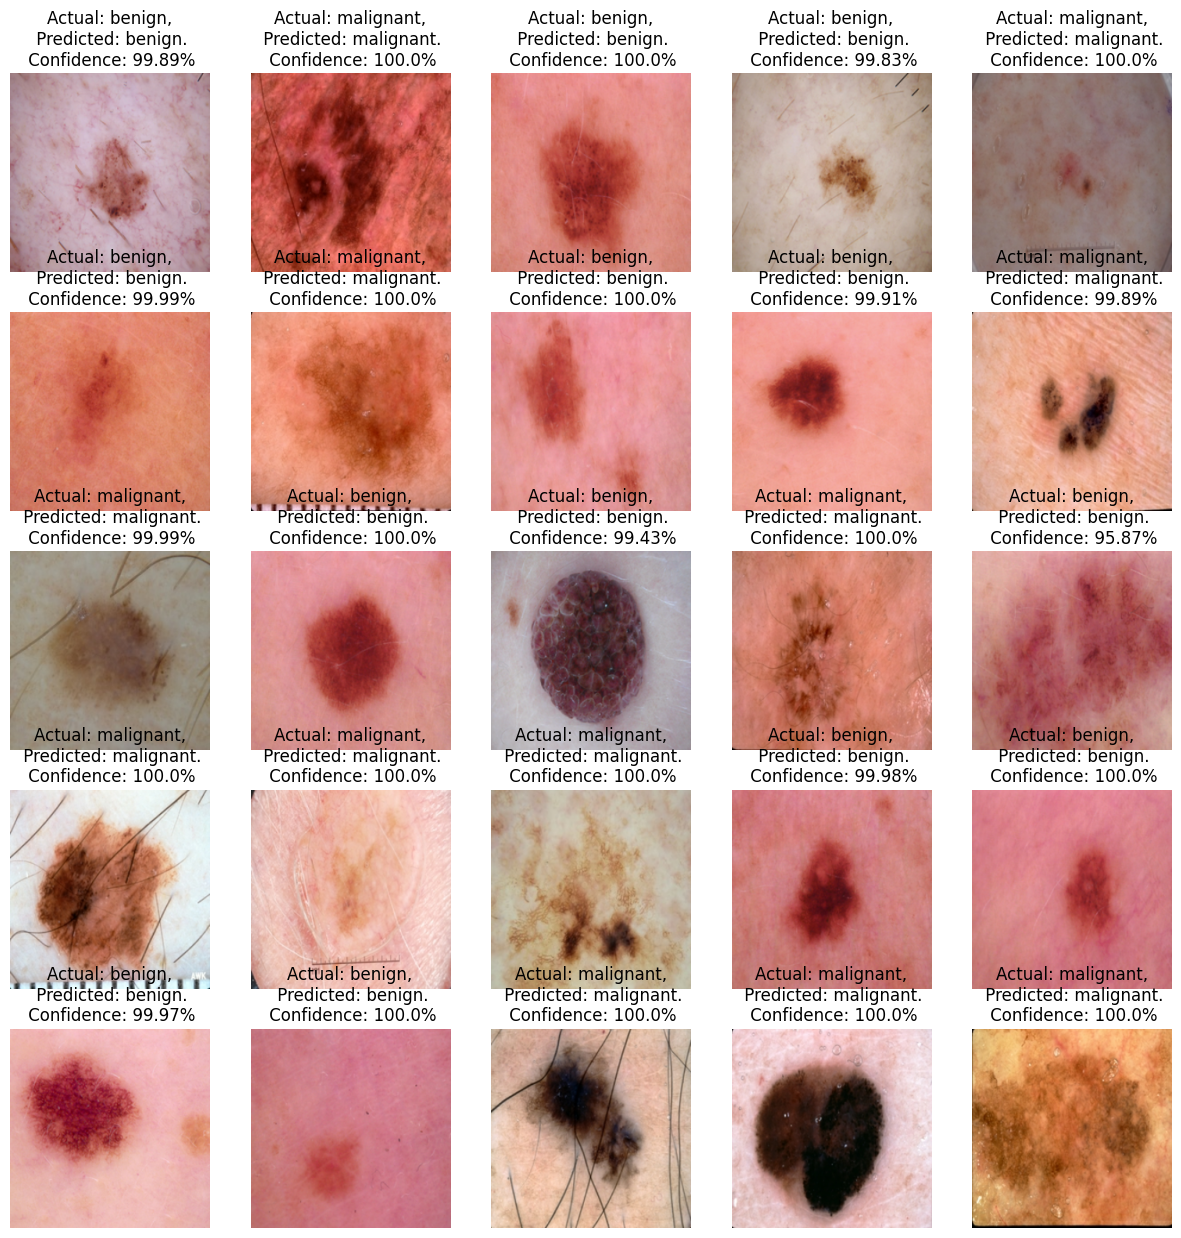

In [ ]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(25):
        ax = plt.subplot(5, 5, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))

        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]]

        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")

        plt.axis("off")

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
predicted_labels = []
true_labels = []
for images, labels in test_ds:
    batch_predicted_labels = model.predict(images)
    batch_predicted_labels = [np.argmax(pred) for pred in batch_predicted_labels]  # Assuming predictions are one-hot encoded
    predicted_labels.extend(batch_predicted_labels)
    true_labels.extend(labels.numpy())
# Compute confusion matrix
conf_matrix = confusion_matrix(true_labels, predicted_labels)
print("Confusion Matrix:")
print(conf_matrix)
# Compute classification report
class_report = classification_report(true_labels, predicted_labels)
print("Classification Report:")
print(class_report)

1/1 [==============================] - 0s 33ms/step
Confusion Matrix:
[[116   3]
 [  2 103]]
Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.97      0.98       119
           1       0.97      0.98      0.98       105

    accuracy                           0.98       224
   macro avg       0.98      0.98      0.98       224
weighted avg       0.98      0.98      0.98       224



1/1 [==============================] - 2s 2s/step


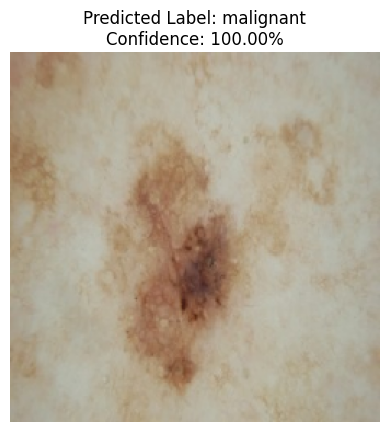

In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

# Load the trained model
model = tf.keras.models.load_model('/content/drive/MyDrive/model_cancer_detection.h5')

def predict_image(image_path):
    # Load and preprocess the image
    image = tf.keras.preprocessing.image.load_img(image_path, target_size=(IMAGE_SIZE, IMAGE_SIZE))
    image = tf.keras.preprocessing.image.img_to_array(image)
    image = np.expand_dims(image, axis=0)
    image = image / 255.0  # Normalize

    # Predict
    prediction = model.predict(image)
    predicted_label = np.argmax(prediction)
    confidence = np.max(prediction) * 100  # Assuming softmax output

    # Convert label to class name if needed
    predicted_label_name = class_names[predicted_label]

    # Plot the image
    plt.imshow(image[0])
    plt.title(f'Predicted Label: {predicted_label_name}\nConfidence: {confidence:.2f}%')
    plt.axis('off')
    plt.show()

# Example usage:
image_path = '/content/drive/MyDrive/vn_data/malignant/10.jpg'
predict_image(image_path)
